In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna
from sklearn.metrics import mean_absolute_error

from numba import njit

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast.models import (
    HistoricAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    AutoARIMA,
    ARIMA,
    MSTL as MSTL_Model,
    AutoETS,
    AutoTBATS
)

from mlforecast import MLForecast

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, TiDE, PatchTST

from utilsforecast.losses import rmse, mae, smape
from utilsforecast.evaluation import evaluate

2026-02-17 02:42:09,205	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2026-02-17 02:42:09,326	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Order of notebook

1. EDA
2. Baselines + Statistical Models
3. Gradient Boosted Trees
4. Neural Networks
5. Hyperparameter tuning
6. Inference

## EDA

- check data distributions
- handle skewdness
- handle missing values cause of DST
- statistical tests and plots to understand tas data better

In [52]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  str    
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), str(1)
memory usage: 2.2 MB


start - 2011-01-01 01:00:00	\
end - 2018-08-03 00:00:00	

In [53]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

In [54]:
df

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
...,...,...
66492,2018-08-02 20:00:00,16437.0
66493,2018-08-02 21:00:00,15590.0
66494,2018-08-02 22:00:00,15086.0
66495,2018-08-02 23:00:00,14448.0


In [55]:
# statsforecast friendly
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'

df = df[['unique_id', 'ds', 'y']]

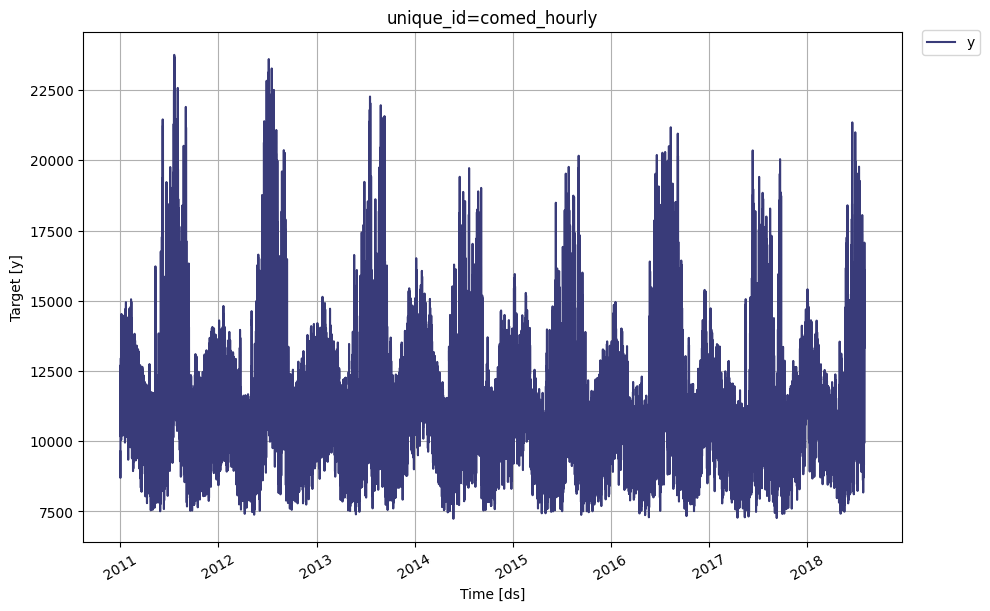

In [56]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


USA Seasons
- Spring `(March-May)` [03-05]
- Summer `(June-Aug)` [06-08]
- Fall `(Sep-Nov)` [09-11]
- Winter `(Dec-Feb)` [12-02]

Some simple findings
- clear baseline around ~11,000
- spikes up to around +23,000 during summer
- clear yearly seasonal pattern

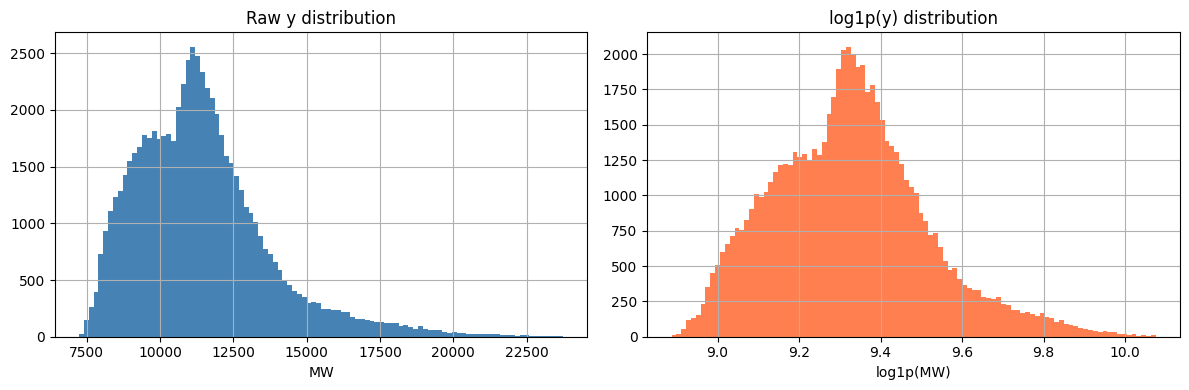

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['y'], bins=100, color='steelblue', edgecolor='none')
axes[0].set_title('Raw y distribution')
axes[0].set_xlabel('MW')

axes[1].hist(np.log1p(df['y']), bins=100, color='coral', edgecolor='none')
axes[1].set_title('log1p(y) distribution')
axes[1].set_xlabel('log1p(MW)')

plt.tight_layout()
plt.show()

- right-skewed and for linear statistical models log-normal distributions are much better

null and duplication checks

In [58]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


In [59]:
# because of DST there can be still some skipped times
# even if i averaged some results in above we still have
# to consider about spring forward day
hourly_date_range = pd.date_range(
    start=df['ds'].min(),
    end=df['ds'].max(),
    freq='h'
)

skipped_hours = hourly_date_range.difference(df['ds'])
print(len(skipped_hours), skipped_hours)

11 DatetimeIndex(['2011-03-13 03:00:00', '2011-11-06 02:00:00',
               '2012-03-11 03:00:00', '2012-11-04 02:00:00',
               '2013-03-10 03:00:00', '2013-11-03 02:00:00',
               '2014-03-09 03:00:00', '2015-03-08 03:00:00',
               '2016-03-13 03:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00'],
              dtype='datetime64[us]', freq=None)


In [60]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


#Daylight saving times are found.

- Spring Forward Day: clocks move forward 1 hour
- Fall Back: clocks move back 1 hour

#Solution One
- Convert it to UTC (uniform and no-gaps)

#`Solution Two`
- Keep local time for human context on electricity consumption
- Linearly interpolate

In [61]:
# remove duplications by averaging
dst_times = [
    "2014-11-02 02:00:00",
    "2015-11-01 02:00:00",
    "2016-11-06 02:00:00",
    "2017-11-05 02:00:00",
]

for t in dst_times:
    t = pd.Timestamp(t)

    rows = df[df['ds'] == t]

    combined_y = rows['y'].sum() / 2

    # keep the first row
    keep_idx = rows.index[0]
    drop_idx = rows.index[1]

    df.loc[keep_idx, 'y'] = combined_y
    df = df.drop(drop_idx)

In [62]:
# linear interpolation
full_range = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='h')})
df = full_range.merge(df, on='ds', how='left')
df['unique_id'] = df['unique_id'].ffill()

# since the electricity consumption within these hours doesnt vary much
df['y'] = df['y'].interpolate(method='linear')

#Decompositions

- Electricity consumptions data tend to have multiple seasonalities

In [15]:
# mstl for daily and weekly seasonal
mstl = MSTL(df['y'], periods=[24, 168], stl_kwargs={'robust': True})
mstl_result = mstl.fit()

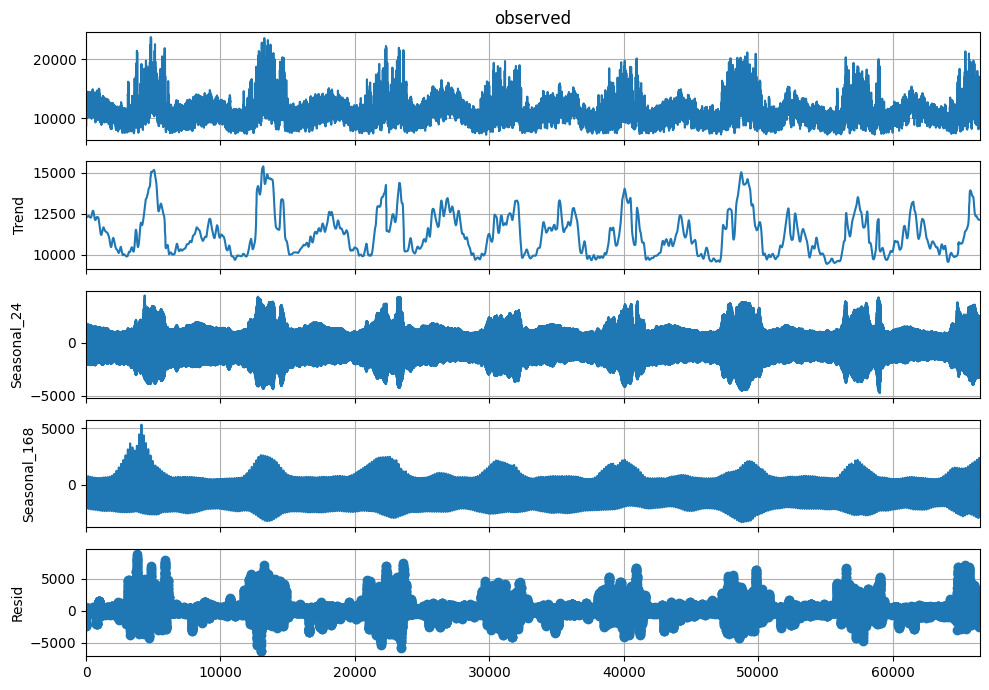

In [16]:
fig = mstl_result.plot()
fig.set_size_inches(10, 7)
plt.tight_layout()
plt.show()

- Trend baseline is slowly declining over the years
- Daily patterns changes overtime
- Weekdays used to consume more electricity but the spread shifted overtime
- Residuals are clearly not whitenoise

The residual mixes annual seasonality leakage with real volatility.\
log1p reduces this variance inflation <strong>(heteroskedasticity)</strong> so MSTL and statistical models behave as intended

#ACF and PACF plots analysis

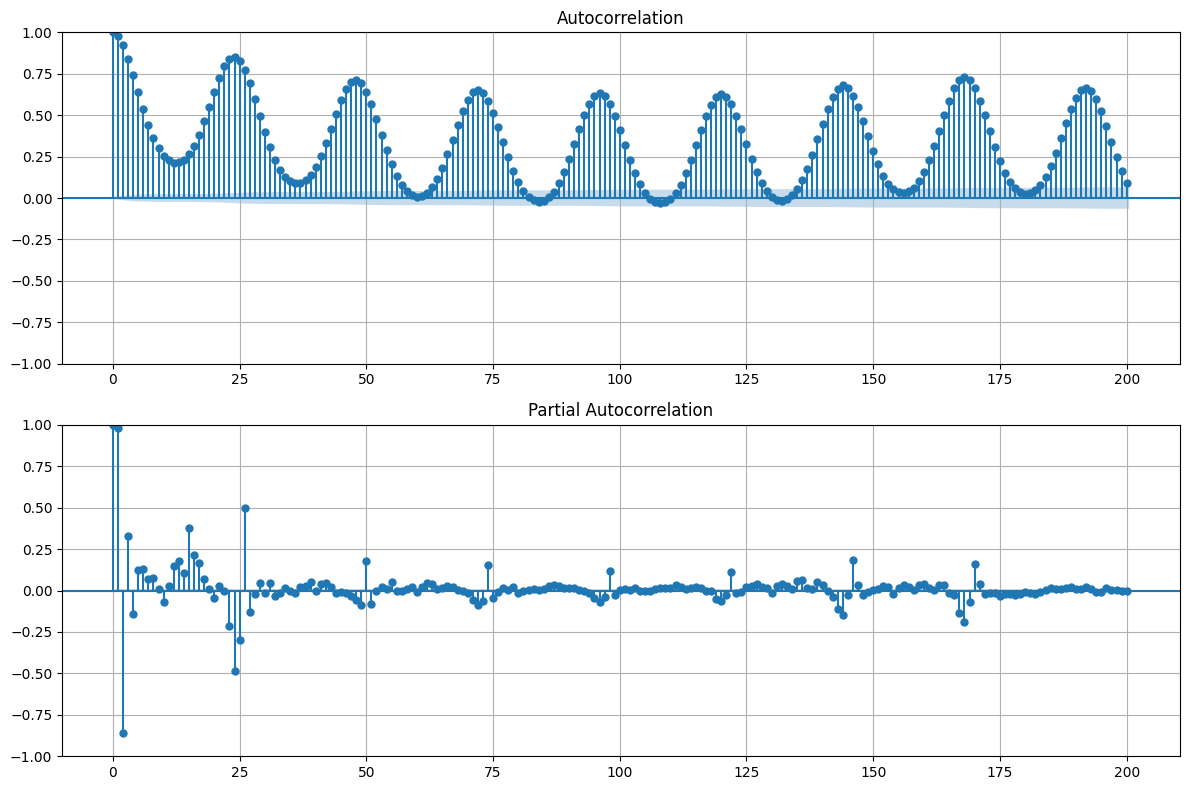

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# lags=200 covers 8 full daily cycles enough room to oberve weekly spikes
plot_acf(df['y'], lags=200, ax=axes[0])
plot_pacf(df['y'], lags=200, ax=axes[1])

plt.tight_layout()
plt.show()

- ACF Findings\
    Very Strong daily patterns (every 24 lags) and amplitudes are barely decaying.\
    The daily seasonality are highly correlated and long-memory.\
    The series is non-stationary and needs differencing.

- PACF Findings\
    The PACF exhibits a strong spike at lag 1 and a clear cutoff after a prominent spike at lag 24, consistent with a seasonal AR(1) structure at the daily period.

<br>

log scaled

In [71]:
df['y_log'] = np.log1p(df['y'])

In [68]:
# use last 14 days as test set (336 hours)
test_size = 24 * 14
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
test = test.drop(columns=['y_log'])

print(f"Train: {train['ds'].min()} to {train['ds'].max()} — {len(train)} rows")
print(f"Test:  {test['ds'].min()} to {test['ds'].max()} — {len(test)} rows")

Train: 2011-01-01 01:00:00 to 2018-07-20 00:00:00 — 66168 rows
Test:  2018-07-20 01:00:00 to 2018-08-03 00:00:00 — 336 rows


In [20]:
train_log_scaled = train[['unique_id', 'ds', 'y_log']].rename(columns={'y_log': 'y'})

## Baselines and StatModels

In [21]:
forecast_horizon = 336 # 14 days

daily_seasonal_length = 24  # daily
weekly_seasonal_length = 168

frequency = 'h' # hourly


sf_baseline = StatsForecast(
    models=[
        Naive(),
        HistoricAverage(),
        RandomWalkWithDrift(),
        SeasonalNaive(season_length=daily_seasonal_length, alias='SeasonalNaive_Daily'),
        SeasonalNaive(season_length=weekly_seasonal_length, alias='SeasonalNaive_Weekly'),
    ],
    freq=frequency,
)

sf_baseline.fit(train_log_scaled)

forecast_baseline_train = sf_baseline.predict(h=forecast_horizon)

In [22]:
sf = StatsForecast(
    models=[
        # taking forever try with manual SARIMA
        # AutoARIMA(season_length=daily_seasonal_length),
        ARIMA(order=(2, 1, 1), seasonal_order=(1, 1, 1), season_length=daily_seasonal_length, alias="SARIMA_211_111_24"),
        AutoETS(season_length=daily_seasonal_length),
        MSTL_Model(season_length=[24, 168]),
    ],
    freq=frequency,
    n_jobs=-1
)

sf.fit(train_log_scaled)

forecast_train = sf.predict(h=forecast_horizon)

In [23]:
cv_baseline_df = sf_baseline.cross_validation(
    h = forecast_horizon,
    df = train_log_scaled,
    n_windows = 5,   # 5 folds
    step_size = forecast_horizon
)

cv_stats_df = sf.cross_validation(
    h = forecast_horizon,
    df = train_log_scaled,
    n_windows = 5,   # 5 folds
    step_size = forecast_horizon
)

In [24]:
# expm1 all value columns before evaluation
cols_to_transform = ['y', 'Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']

cv_df_baseline_orig = cv_baseline_df.copy()
cv_df_baseline_orig[cols_to_transform] = np.expm1(cv_baseline_df[cols_to_transform])

cv_df_baseline_orig.head()

,unique_id,ds,cutoff,y,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-05-11 01:00:00,2018-05-11,9118.0,9897.0,11184.387445,9897.004181,9804.0,9408.0
1,comed_hourly,2018-05-11 02:00:00,2018-05-11,8542.0,9897.0,11184.387445,9897.008363,9093.0,8913.0
2,comed_hourly,2018-05-11 03:00:00,2018-05-11,8192.0,9897.0,11184.387445,9897.012544,8671.0,8616.0
3,comed_hourly,2018-05-11 04:00:00,2018-05-11,7959.0,9897.0,11184.387445,9897.016725,8397.0,8440.0
4,comed_hourly,2018-05-11 05:00:00,2018-05-11,7895.0,9897.0,11184.387445,9897.020907,8267.0,8361.0


In [25]:
# expm1 all value columns before evaluation
cols_to_transform = ['y', 'SARIMA_211_111_24', 'AutoETS', 'MSTL']

cv_df_orig = cv_stats_df.copy()
cv_df_orig[cols_to_transform] = np.expm1(cv_stats_df[cols_to_transform])

cv_df_orig.head()

,unique_id,ds,cutoff,y,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,2018-05-11 01:00:00,2018-05-11,9118.0,9119.552128,9014.637119,9184.592432
1,comed_hourly,2018-05-11 02:00:00,2018-05-11,8542.0,8542.994053,8453.266450,8621.473438
2,comed_hourly,2018-05-11 03:00:00,2018-05-11,8192.0,8187.101858,8126.861525,8260.577739
3,comed_hourly,2018-05-11 04:00:00,2018-05-11,7959.0,7960.598112,7931.588313,8036.564962
4,comed_hourly,2018-05-11 05:00:00,2018-05-11,7895.0,7871.457642,7873.176223,7941.377794


In [26]:
eval_baseline_res = evaluate(
    cv_df_baseline_orig,
    metrics=[rmse, mae],
    models=['Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']
)

eval_baseline_res

,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-05-11,rmse,1573.317034,2021.805051,1573.188552,1251.752293,783.918040
1,comed_hourly,2018-05-25,rmse,2640.428476,2802.699306,2641.604994,1893.598125,2851.622210
2,comed_hourly,2018-06-08,rmse,3185.315850,3103.840225,3182.841666,2317.793020,3077.931451
3,comed_hourly,2018-06-22,rmse,4358.487092,4001.752031,4356.043976,3570.158116,3294.612570
4,comed_hourly,2018-07-06,rmse,2937.199625,3824.352253,2938.778844,2476.430247,2913.137095
5,comed_hourly,2018-05-11,mae,1342.303571,1685.648036,1342.287540,888.071429,526.529762
6,comed_hourly,2018-05-25,mae,2225.345238,2244.465194,2227.084897,1590.767857,2168.071429
7,comed_hourly,2018-06-08,mae,2385.392857,2332.843730,2383.567339,1704.011905,2234.916667
8,comed_hourly,2018-06-22,mae,3407.625000,3109.863877,3405.482175,2756.482143,2751.232143
9,comed_hourly,2018-07-06,mae,2479.023810,3066.007965,2479.729913,1936.738095,2258.523810


In [27]:
eval_res = evaluate(
    cv_df_orig,
    metrics=[rmse, mae],
    models=['SARIMA_211_111_24', 'AutoETS', 'MSTL']
)

eval_res

,unique_id,cutoff,metric,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,2018-05-11,rmse,1350.586220,1174.803102,720.389047
1,comed_hourly,2018-05-25,rmse,5740.538659,2111.356061,1926.436582
2,comed_hourly,2018-06-08,rmse,2577.207524,2510.610791,3044.788620
3,comed_hourly,2018-06-22,rmse,5535.163112,3717.958328,3238.003042
4,comed_hourly,2018-07-06,rmse,1941.096622,1918.396338,1789.856537
5,comed_hourly,2018-05-11,mae,1064.738042,802.719089,473.284739
6,comed_hourly,2018-05-25,mae,4454.925651,1747.754378,1519.489689
7,comed_hourly,2018-06-08,mae,1900.964236,1814.865656,2050.577649
8,comed_hourly,2018-06-22,mae,4595.849018,3059.165384,2471.054828
9,comed_hourly,2018-07-06,mae,1530.226191,1478.020638,1427.726608


In [28]:
eval_baseline_res[eval_baseline_res['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

SeasonalNaive_Daily     2301.946360
SeasonalNaive_Weekly    2584.244273
RWD                     2938.491606
Naive                   2938.949615
HistoricAverage         3150.889773
dtype: float64

In [29]:
eval_res[eval_res['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

MSTL                 2143.894765
AutoETS              2286.624924
SARIMA_211_111_24    3428.918427
dtype: float64

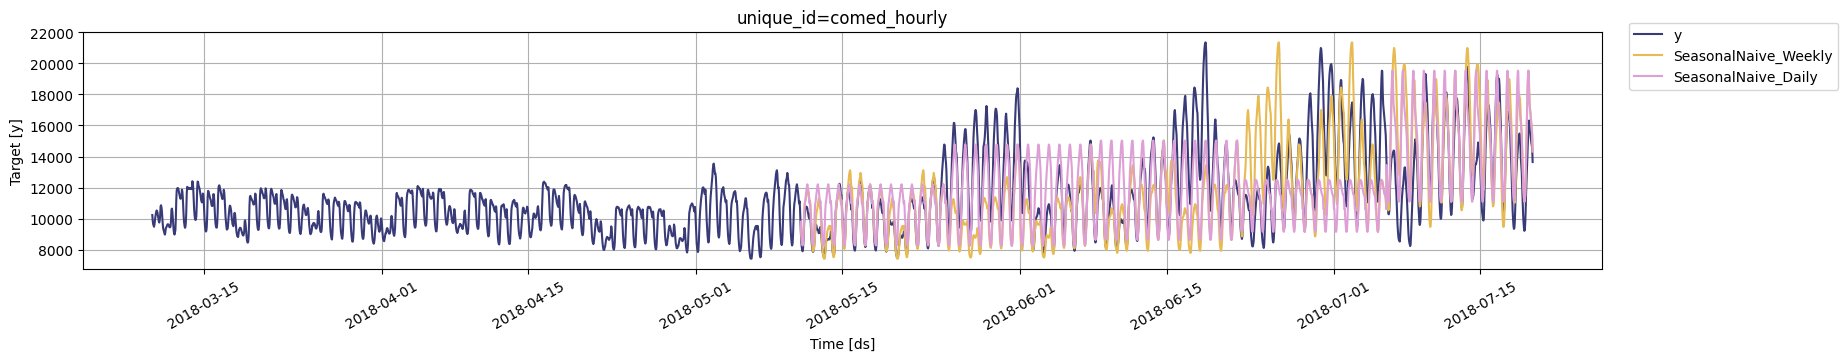

In [30]:
StatsForecast.plot(
    train[63000:],
    cv_df_baseline_orig[
        [
            'unique_id', 'ds', 
            # 'Naive', 'HistoricAverage', 'RWD', 
            'SeasonalNaive_Weekly',
            'SeasonalNaive_Daily', 
        ]
    ]
)

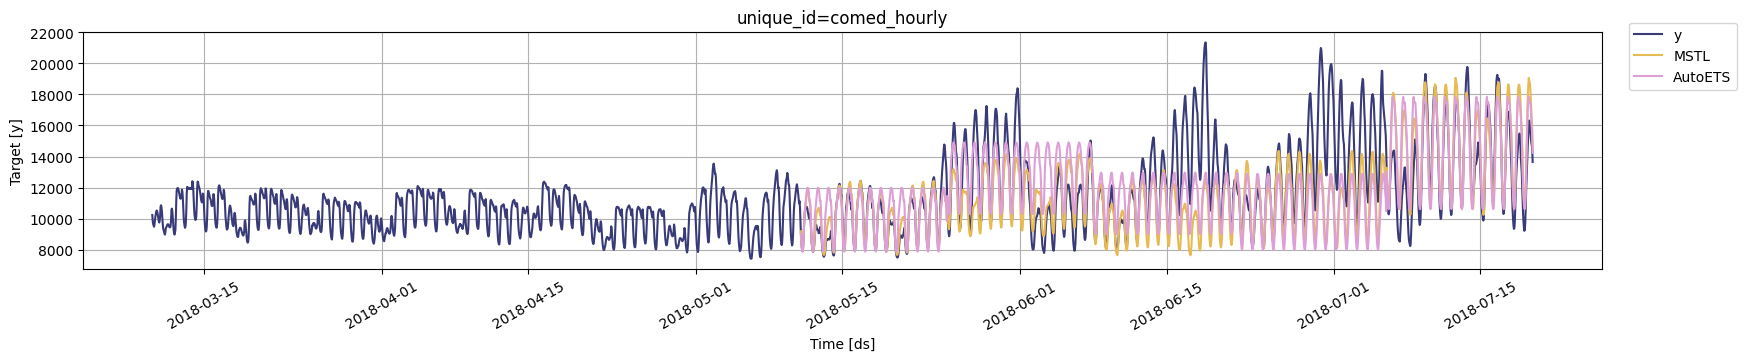

In [31]:
StatsForecast.plot(
    train[63000:],
    cv_df_orig[
        [
            'unique_id', 'ds', 
            # 'SARIMA_211_111_24', 
            'MSTL',
            'AutoETS',
        ]
    ]
)

#Evaluation on test set for baseline and statsmodels

In [32]:
baseline_model_cols = ['Naive', 'HistoricAverage', 'RWD', 'SeasonalNaive_Daily', 'SeasonalNaive_Weekly']
stat_model_cols = ['SARIMA_211_111_24', 'AutoETS', 'MSTL']
all_model_cols = baseline_model_cols + stat_model_cols

baseline = forecast_baseline_train.copy()
stat_models = forecast_train.copy()

baseline[baseline_model_cols] = np.expm1(forecast_baseline_train[baseline_model_cols])
stat_models[stat_model_cols] = np.expm1(forecast_train[stat_model_cols])

In [33]:
forecast_all = stat_models[['unique_id', 'ds'] + stat_model_cols].merge(
    baseline[['unique_id', 'ds'] + baseline_model_cols],
    on=['unique_id', 'ds'],
    how='inner'
)

forecast_all.head()

,unique_id,ds,SARIMA_211_111_24,AutoETS,MSTL,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,comed_hourly,2018-07-20 01:00:00,12585.741222,12288.665540,12469.299581,13645.0,11203.84334,13645.071844,11089.0,13357.0
1,comed_hourly,2018-07-20 02:00:00,11705.664970,11461.549333,11551.060932,13645.0,11203.84334,13645.143687,10331.0,12296.0
2,comed_hourly,2018-07-20 03:00:00,11049.110572,10843.219438,10905.954745,13645.0,11203.84334,13645.215532,9791.0,11618.0
3,comed_hourly,2018-07-20 04:00:00,10584.454021,10404.560556,10447.645502,13645.0,11203.84334,13645.287376,9422.0,11076.0
4,comed_hourly,2018-07-20 05:00:00,10326.099274,10153.034504,10206.838322,13645.0,11203.84334,13645.359222,9209.0,10709.0


In [34]:
eval_df = test.merge(
    forecast_all,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df.head()

,ds,unique_id,y,SARIMA_211_111_24,AutoETS,MSTL,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly
0,2018-07-20 01:00:00,comed_hourly,12682.0,12585.741222,12288.665540,12469.299581,13645.0,11203.84334,13645.071844,11089.0,13357.0
1,2018-07-20 02:00:00,comed_hourly,11929.0,11705.664970,11461.549333,11551.060932,13645.0,11203.84334,13645.143687,10331.0,12296.0
2,2018-07-20 03:00:00,comed_hourly,11327.0,11049.110572,10843.219438,10905.954745,13645.0,11203.84334,13645.215532,9791.0,11618.0
3,2018-07-20 04:00:00,comed_hourly,10895.0,10584.454021,10404.560556,10447.645502,13645.0,11203.84334,13645.287376,9422.0,11076.0
4,2018-07-20 05:00:00,comed_hourly,10676.0,10326.099274,10153.034504,10206.838322,13645.0,11203.84334,13645.359222,9209.0,10709.0


In [35]:
final_eval_res = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=all_model_cols
)

final_eval_res

,unique_id,metric,Naive,HistoricAverage,RWD,SeasonalNaive_Daily,SeasonalNaive_Weekly,SARIMA_211_111_24,AutoETS,MSTL
0,comed_hourly,mae,2265.919643,2088.059641,2269.639404,1281.848214,2164.770833,3120.868863,1510.665218,1717.479344
1,comed_hourly,rmse,2673.405438,2610.644983,2678.620656,1703.781918,2665.489443,3518.010306,1909.531132,1996.744791


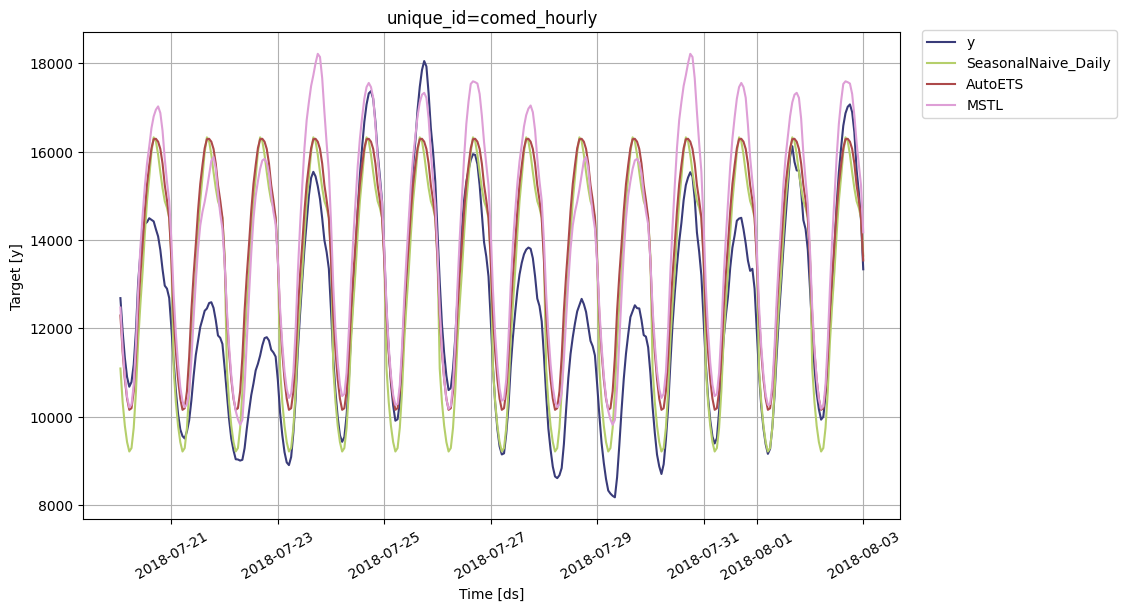

In [36]:
f = sf.plot(
    test,
    forecast_all,
    models=[
        'SeasonalNaive_Daily', 
        'AutoETS', 
        'MSTL',
    ]
)
f.set_figwidth(9)
f.set_figheight(6)
f

- AutoETL becomes seasonal naive like
- MSTL over predicts
- SeasonalNaive_Daily fits the best in here

with mae:`1281.848214`\
rmse: `1703.781918`

## Machine Learning GBM models


#### `Feature Engineering`

Since comparing baseline methods with statistical methods.\
SeasonalNaive_Daily is has the highest accruacy and it means\
Today at 3pm ~= Yesterday at 3pm => `residual_24_hour = y_t - y_t-24`


List of features that will be added: <b>Iterated through checking feature importance</b>
- Residual features
- Lag features
- Rolling statistics 24, 168
- Calendar Features
- Fourier terms - optional

In [72]:
df = df.drop(columns=['y_log'])

In [73]:
# residual_24 = y_t - y_t-24
@njit
def residual_24(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 24:
            out[i] = np.nan
        else:
            out[i] = x[i] - x[i - 24]
    return out

# residual_168 = y_t - y_t-168
@njit
def residual_168(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 168:
            out[i] = np.nan
        else:
            out[i] = x[i] - x[i - 168]
    return out

# pattern deviation weekly
# residual_168_24 = (y_t - y_t-24) - (y_t-168 - y_t-192)
@njit
def residual_168_24(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 192:
            out[i] = np.nan
        else:
            d_now  = x[i]     - x[i - 24]
            d_week = x[i-168] - x[i - 192]
            out[i] = d_now - d_week
    return out

In [74]:
# calendar features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.day_of_week
df['month'] = df['ds'].dt.month

cal = USFederalHolidayCalendar()
us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
ds_norm = df['ds'].dt.normalize()

df['is_holiday'] = ds_norm.isin(us_holidays).astype(int)

In [75]:
# fourier harmonics for annual cycle
day_of_year = df['ds'].dt.dayofyear
for k in range(1, 4):
    # k=3 cycles per year
    df[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
    df[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

#Exogeneous Features for mlforecast

In [76]:
exogeneous_features = [
    'hour', 'dayofweek', 'month',
    'is_holiday',
    'sin_annual_1', 'cos_annual_1',
    'sin_annual_2', 'cos_annual_2',
    'sin_annual_3', 'cos_annual_3',
]

In [77]:
# drop nan-values from first shifts
df_ml_ready = df.dropna().reset_index(drop=True)

test_size = 24 * 14
train_ml = df_ml_ready.iloc[:-test_size]
test_ml  = df_ml_ready.iloc[-test_size:]

In [78]:
df_ml_ready

,ds,unique_id,y,hour,dayofweek,month,is_holiday,sin_annual_1,cos_annual_1,sin_annual_2,cos_annual_2,sin_annual_3,cos_annual_3
0,2011-01-01 01:00:00,comed_hourly,9631.0,1,5,1,0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
1,2011-01-01 02:00:00,comed_hourly,9273.0,2,5,1,0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
2,2011-01-01 03:00:00,comed_hourly,9011.0,3,5,1,0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
3,2011-01-01 04:00:00,comed_hourly,8741.0,4,5,1,0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
4,2011-01-01 05:00:00,comed_hourly,8694.0,5,5,1,0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66499,2018-08-02 20:00:00,comed_hourly,16437.0,20,3,8,0,-0.513901,-0.857849,0.881699,0.471812,-0.998830,0.048363
66500,2018-08-02 21:00:00,comed_hourly,15590.0,21,3,8,0,-0.513901,-0.857849,0.881699,0.471812,-0.998830,0.048363
66501,2018-08-02 22:00:00,comed_hourly,15086.0,22,3,8,0,-0.513901,-0.857849,0.881699,0.471812,-0.998830,0.048363
66502,2018-08-02 23:00:00,comed_hourly,14448.0,23,3,8,0,-0.513901,-0.857849,0.881699,0.471812,-0.998830,0.048363


In [43]:
mlf = MLForecast(
    models={
        'xgboost': XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        # fit with linear tree for lgbm for stronger extrapolation since we saw trend in summer season peaks
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0, linear_tree=True),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        # mlforecast will update them recursively at prediction steps
        1: [residual_24, residual_168, residual_168_24],
        24: [(rolling_mean, 24), (rolling_std, 24), (rolling_max, 24), (rolling_min, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168), (rolling_max, 168), (rolling_min, 168)],
    },
)

mlf.fit(train_ml[['unique_id', 'ds', 'y'] + exogeneous_features], static_features=[])

future_exog = test_ml[['unique_id', 'ds'] + exogeneous_features]
preds = mlf.predict(h=336, X_df=future_exog)

#feature importance

In [44]:
feature_names = mlf.ts.features_order_

lgbm_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mlf.models_['lgbm'].feature_importances_
}).sort_values('importance', ascending=False)

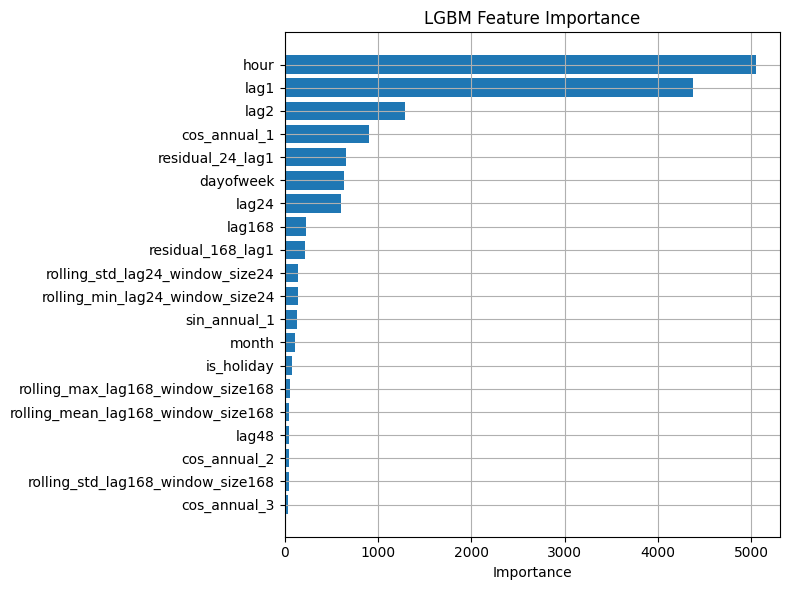

In [45]:
top_k = 20

df_plot = lgbm_imp.head(top_k).sort_values('importance')

plt.figure(figsize=(8, 6))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Importance')
plt.title('LGBM Feature Importance')
plt.tight_layout()
plt.show()

In [46]:
cv_ml = mlf.cross_validation(
    df=train_ml[['unique_id', 'ds', 'y'] + exogeneous_features],
    h=336,
    n_windows=5,
    step_size=336,
    static_features=[]
)

In [47]:
eval_ml = evaluate(
    cv_ml,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

eval_ml[eval_ml['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

lgbm        1699.493618
xgboost     2324.950753
catboost    2562.135348
dtype: float64

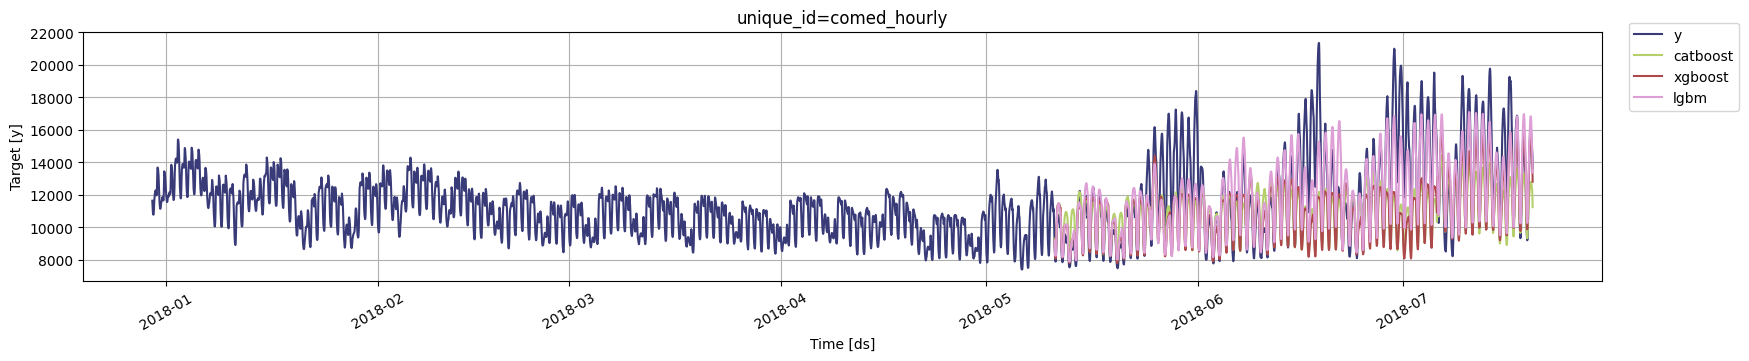

In [48]:
# comparing across 5 folds
StatsForecast.plot(
    train_ml[24*365*7:],
    cv_ml[
        [
            'unique_id', 'ds', 
            'catboost',
            'xgboost',
            'lgbm',
        ]
    ]
)

- shapes are mostly correct but the amplitudes still underpredicts in summer time
- summer spikes are harder to predict | extrapolation is necessary -> linear leafs in LGBM
- adding `weather | temperature` features will surely improve the model

#evaluation

In [49]:
# merge predictions with actual test values
eval_df = test_ml[['unique_id', 'ds', 'y']].merge(
    preds,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df

,unique_id,ds,y,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12682.0,12567.421875,12676.695998,12602.220270
1,comed_hourly,2018-07-20 02:00:00,11929.0,11629.375000,11864.014138,11689.239869
2,comed_hourly,2018-07-20 03:00:00,11327.0,11027.214844,11203.966364,11020.945209
3,comed_hourly,2018-07-20 04:00:00,10895.0,10600.462891,10693.642482,10561.886663
4,comed_hourly,2018-07-20 05:00:00,10676.0,10390.158203,10496.726012,10262.380934
...,...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,16437.0,15019.197266,12504.065746,14895.166665
332,comed_hourly,2018-08-02 21:00:00,15590.0,14572.433594,12351.197490,14471.139644
333,comed_hourly,2018-08-02 22:00:00,15086.0,14151.581055,12173.332592,14108.706462
334,comed_hourly,2018-08-02 23:00:00,14448.0,13767.311523,11854.083006,13669.356395


In [50]:
final_eval_ml = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

final_eval_ml

,unique_id,metric,xgboost,catboost,lgbm
0,comed_hourly,mae,975.109570,1118.621382,762.572879
1,comed_hourly,rmse,1165.331338,1558.271639,920.568952


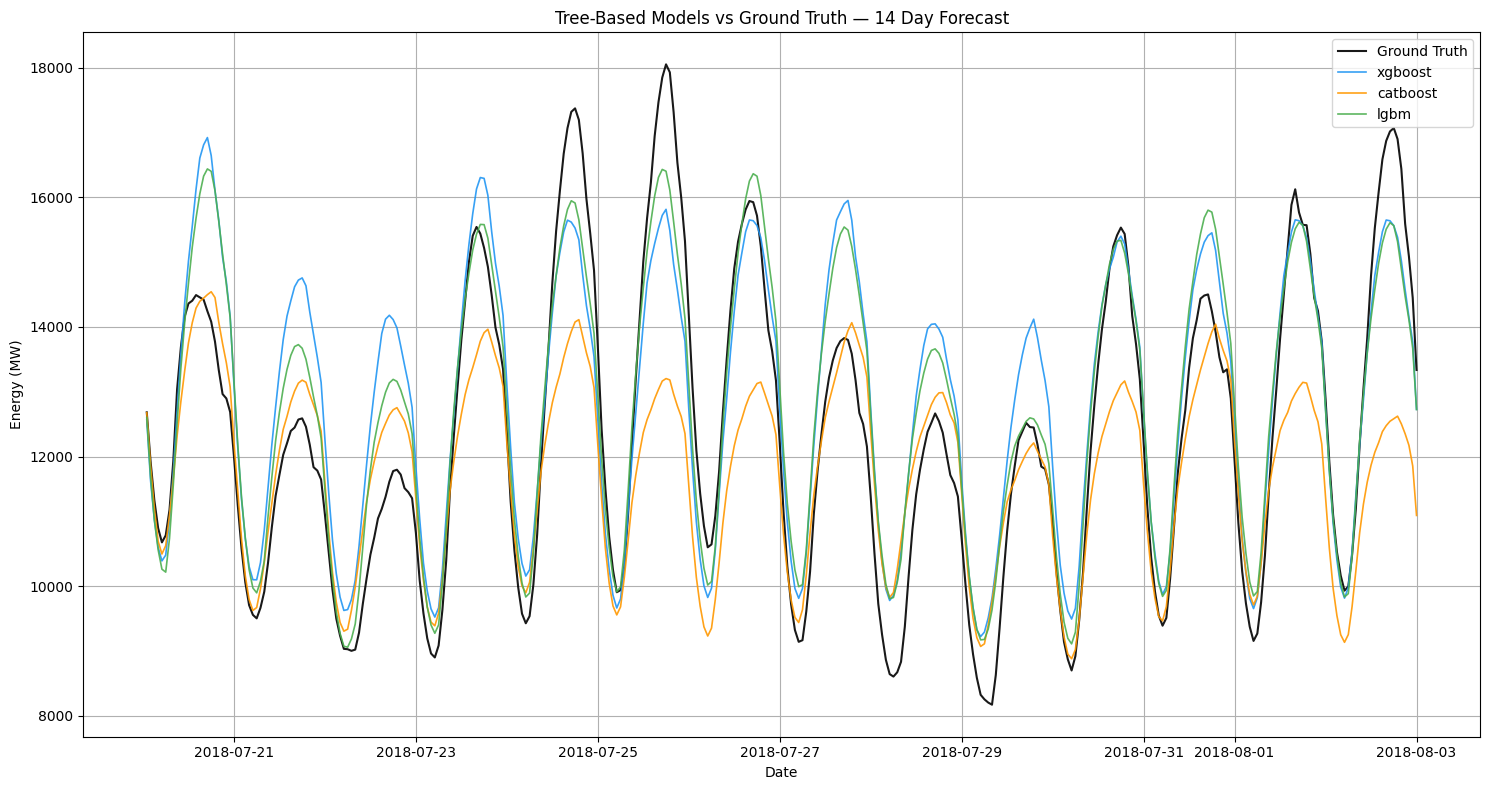

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(eval_df['ds'], eval_df['y'], label='Ground Truth', color='black', linewidth=1.5, alpha=0.9)

colors = {'xgboost': '#2196F3', 'catboost': '#FF9800', 'lgbm': '#4CAF50'}
for model, color in colors.items():
    ax.plot(eval_df['ds'], eval_df[model], label=f'{model}', color=color, linewidth=1.2, linestyle='-', alpha=0.9)

ax.set_title('Tree-Based Models vs Ground Truth — 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

Tree-based models clearly beats Naive methods and Statistical models.\

`LGBM` fits best: with mae: `762.572879` and rmse: `920.568952`

## DeepLearning Models

NHits | TiDE | PatchTST

In [ ]:
# ditch other cols
df = df[['unique_id', 'ds', 'y']]

In [ ]:
test_size = 24 * 14

train_dl = df.iloc[:-test_size]
test_dl  = df.iloc[-test_size:]

In [ ]:
forecast_horizon = 336
input_size       = 336 * 2  # 4 weeks lookback

# simple calendar features as exogeneous features for NHits and TiDe models
futr_exog_cols = ['hour', 'dayofweek', 'month', 'is_holiday']

In [ ]:
def build_nf_futr_exog(df):
    df = df.copy()
    cal         = USFederalHolidayCalendar()
    us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
    df['hour']       = df['ds'].dt.hour
    df['dayofweek']  = df['ds'].dt.dayofweek
    df['month']      = df['ds'].dt.month
    df['is_holiday'] = df['ds'].dt.normalize().isin(us_holidays).astype(int)
    return df

In [ ]:
# NHITS, TiDE, PatchTST
def get_nf_models(max_steps):
    return [
        NHITS(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            futr_exog_list=futr_exog_cols,
            accelerator='auto',
        ),
        TiDE(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            futr_exog_list=futr_exog_cols,
            accelerator='auto',
        ),
        PatchTST(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            accelerator='auto',
        ),
    ]

In [ ]:
train_nf = build_nf_futr_exog(train_ml[['unique_id', 'ds', 'y']])

# train + test
full_nf  = build_nf_futr_exog(
    pd.concat([
        train_ml[['unique_id', 'ds', 'y']],
        test_ml[['unique_id', 'ds', 'y']]
    ]).reset_index(drop=True)
)

test_futr = build_nf_futr_exog(
    test_ml[['unique_id', 'ds']].copy()
)[['unique_id', 'ds'] + futr_exog_cols]

#cv neuralforecast

In [ ]:
nf_cv = NeuralForecast(models=get_nf_models(max_steps=1500), freq='h')

cv_nf = nf_cv.cross_validation(
    df=train_nf,
    n_windows=5,
    step_size=forecast_horizon,
    val_size=forecast_horizon,
)

In [ ]:
eval_nf_cv = evaluate(
    cv_nf,
    metrics=[mae, rmse],
    models=['NHITS', 'TiDE', 'PatchTST']
)

eval_nf_cv

In [ ]:
eval_nf_cv.drop(columns=['unique_id', 'cutoff']).groupby('metric').mean()

In [ ]:
cutoffs = cv_nf['cutoff'].unique()
colors  = {'NHITS': '#2196F3', 'TiDE': '#FF9800', 'PatchTST': '#9C27B0'}

fig, axes = plt.subplots(len(cutoffs), 1, figsize=(15, 4 * len(cutoffs)), sharex=False)

for ax, cutoff in zip(axes, cutoffs):
    fold = cv_nf[cv_nf['cutoff'] == cutoff]

    ax.plot(fold['ds'], fold['y'],
            color='black', linewidth=2, label='Ground Truth')

    for model in ['NHITS', 'TiDE', 'PatchTST']:
        mae_val = fold[model].sub(fold['y']).abs().mean()
        ax.plot(fold['ds'], fold[model],
                color=colors[model], linewidth=1.2,
                linestyle='--', alpha=0.85,
                label=f'{model}  MAE:{mae_val:.0f}')

    ax.set_title(f'Cutoff: {str(cutoff)[:10]}', fontsize=10)
    ax.set_ylabel('Energy (MW)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
fig.suptitle('DL Models — CV Predictions Across Folds', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(eval_df_nf['ds'], eval_df_nf['y'],
        color='black', linewidth=2, label='Ground Truth')

for model, color in colors.items():
    mae_val  = final_eval_nf[final_eval_nf['metric'] == 'mae'][model].values[0]
    rmse_val = final_eval_nf[final_eval_nf['metric'] == 'rmse'][model].values[0]
    ax.plot(eval_df_nf['ds'], eval_df_nf[model],
            color=color, linewidth=1.2, linestyle='--', alpha=0.85,
            label=f'{model}  MAE:{mae_val:.0f}  RMSE:{rmse_val:.0f}')

ax.set_title('DL Models vs Ground Truth — 14 Day Forecast', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Inference

Two weeks ahead using LightGBM

In [79]:
mlf_final = MLForecast(
    models={
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0, linear_tree=True),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        # mlforecast will update them recursively at prediction steps
        1: [residual_24, residual_168, residual_168_24],
        24: [(rolling_mean, 24), (rolling_std, 24), (rolling_max, 24), (rolling_min, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168), (rolling_max, 168), (rolling_min, 168)],
    },
)

mlf_final.fit(
    df_ml_ready[['unique_id', 'ds', 'y'] + exogeneous_features],
    static_features=[]
)

MLForecast(models=[lgbm], freq=h, lag_features=['lag1', 'lag2', 'lag24', 'lag48', 'lag168', 'lag336', 'residual_24_lag1', 'residual_168_lag1', 'residual_168_24_lag1', 'rolling_mean_lag24_window_size24', 'rolling_std_lag24_window_size24', 'rolling_max_lag24_window_size24', 'rolling_min_lag24_window_size24', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_max_lag168_window_size168', 'rolling_min_lag168_window_size168'], date_features=[], num_threads=1)

In [80]:
# build future featu

last_ds     = df_ml_ready['ds'].max()
future_ds   = pd.date_range(start=last_ds + pd.Timedelta(hours=1), periods=336, freq='h')
future_exog = pd.DataFrame({'unique_id': 'comed_hourly', 'ds': future_ds})

future_exog['hour']       = future_exog['ds'].dt.hour
future_exog['dayofweek']  = future_exog['ds'].dt.dayofweek
future_exog['month']      = future_exog['ds'].dt.month

us_holidays_future = cal.holidays(start=future_exog['ds'].min(), end=future_exog['ds'].max())
ds_norm_future     = future_exog['ds'].dt.normalize()
future_exog['is_holiday']            = ds_norm_future.isin(us_holidays_future).astype(int)

doy = future_exog['ds'].dt.dayofyear
for k in range(1, 4):
    future_exog[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * doy / 365.25)
    future_exog[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * doy / 365.25)

In [81]:
future_preds = mlf_final.predict(
    h=336,
    X_df=future_exog[['unique_id', 'ds'] + exogeneous_features]
)

future_preds

,unique_id,ds,lgbm
0,comed_hourly,2018-08-03 01:00:00,12266.831049
1,comed_hourly,2018-08-03 02:00:00,11429.390443
2,comed_hourly,2018-08-03 03:00:00,10823.752174
3,comed_hourly,2018-08-03 04:00:00,10415.644776
4,comed_hourly,2018-08-03 05:00:00,10170.094806
...,...,...,...
331,comed_hourly,2018-08-16 20:00:00,14536.263080
332,comed_hourly,2018-08-16 21:00:00,14151.497513
333,comed_hourly,2018-08-16 22:00:00,13825.266425
334,comed_hourly,2018-08-16 23:00:00,13289.988817


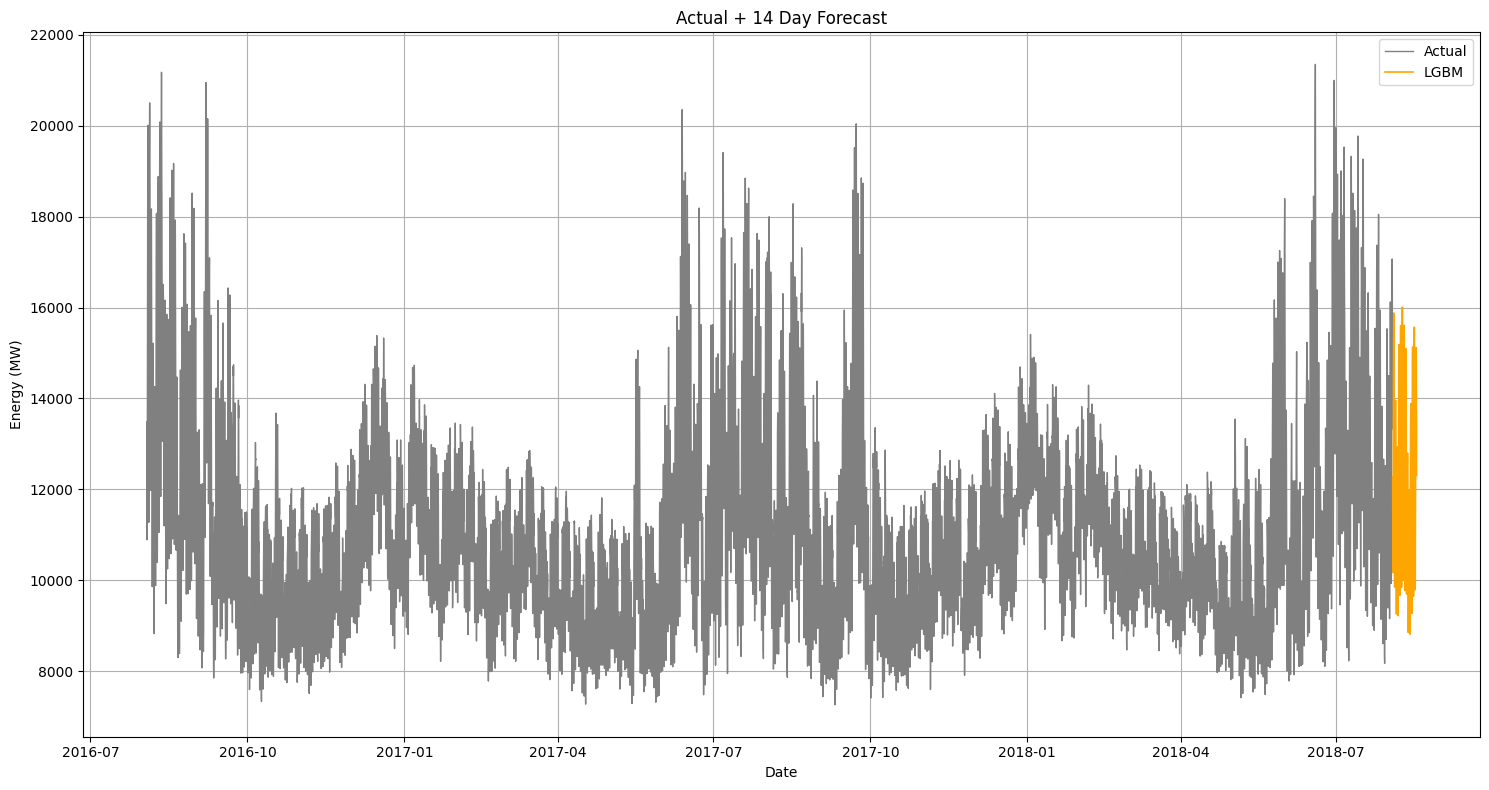

In [82]:
fig, ax = plt.subplots(figsize=(15, 8))

# last 2 years + 2 weeks forecasted
zoom = df_ml_ready.iloc[-24*365*2:]

ax.plot(zoom['ds'], zoom['y'], color='gray', linewidth=1, label='Actual')
ax.plot(future_preds['ds'], future_preds['lgbm'], color='#ffA500', linewidth=1.2, linestyle='-', label='LGBM')

ax.set_title('Actual + 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()